# Prerequisites

In [1]:
!pip install casadi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 MB 7.0 MB/s eta 0:00:00


In [2]:
# Definitions
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='jshtml')

from matplotlib.animation import FuncAnimation

def animate_satellite(trajectory, resolution_Hz=15, duration=None, fig_size=8):
    plt.ioff()
    trajectory = np.array(trajectory)
    trajectory = trajectory.T[0:2].T
    if len(trajectory.shape) == 1:
        trajectory = trajectory.reshape(trajectory.size, 1)
    if trajectory.shape == (trajectory.size, 1):
        trajectory = np.stack((trajectory.T[0], np.zeros(trajectory.size))).T
    if duration == None:
        frames = range(trajectory.shape[0])
    else:
        frames = range(int(duration * resolution_Hz))
    fig, ax = plt.subplots(figsize=(fig_size, fig_size))
    # set the axes limits
    ax.axis([-2,2,-2, 2])
    ax.set_aspect("equal")
    # create a point in the axes
    plt.grid()
    ax.plot(0, 0, markersize=215, marker="o")
    t = np.linspace(0, 2 * np.pi, 1000)
    ax.plot(1.5 * np.cos(t), 1.5 * np.sin(t), "k--")
    plt.text(0, 0, 'Earth', horizontalalignment='center', verticalalignment='center', color='white')
    plt.text(0, -1.7, 'Orbit', horizontalalignment='center', verticalalignment='center', color='black')
    point, = ax.plot(0,1, marker="o")

    # Updating function, to be repeatedly called by the animation
    def update(t):
        # obtain point coordinates
        x,y = trajectory[int(t) % trajectory.shape[0]]
        # set point's coordinates
        point.set_data([x],[y])
        return point,


    ani = FuncAnimation(fig, update, interval=1000/resolution_Hz, blit=True, repeat=True,
                    frames=frames)
    plt.ion()
    return ani

In [3]:
from scipy.linalg import norm

class ParametrizedDiscreteTimeSystem:
    def __init__(self,
                 state_transition_function,  # f(., .)
                 initial_state,              # x_0
                 running_reward,
                 discount
                 ):
      self.__state_transition_function = state_transition_function
      self.__initial_state = initial_state
      self.__running_reward = running_reward
      self.__discount = discount

    def run_with_feedback_controller(self,
                                     feedback_controller,
                                     steps=100):
      trajectory = [self.__initial_state]
      actions = []
      time = 0
      total_reward = 0
      accumulated_discount = 1
      for _ in range(steps):
        current_state = trajectory[-1]
        control_input = feedback_controller(current_state, time) if time < 10 else np.zeros(2)
        actions.append(control_input)
        try:
            next_state = self.__state_transition_function(current_state, control_input)
            total_reward += self.__running_reward(current_state, control_input) * accumulated_discount
            accumulated_discount *= self.__discount
        except OverflowError:
            print("The trajectory blew up. Ending the episode prematurely.")
            return np.array(trajectory), np.array(actions), total_reward
        trajectory.append(next_state)
        time += 1
      return np.array(trajectory), np.array(actions), total_reward

In [56]:
from scipy.integrate import quad, solve_ivp

satellite_initial_state = np.array([0, 1.1, 0.05, 0.05])


def satellite_dynamics_function(state_continuous, control_input): # HINT: You will need this function.
    drift = np.zeros(4)
    drift[0:2] = state_continuous[2:] if norm(state_continuous[0:2]) >= 1 else 0
    drift[2:] = -0.03*state_continuous[0:2] / norm(state_continuous[0:2])**3 + control_input
    return drift

def satellite_transition_function(state, control_input): ## ERASE
    def f(t, y):
        return satellite_dynamics_function(y, control_input)
    next_state = solve_ivp(f, (0, 1), state).y.T[-1]
    return next_state

def satellite_running_reward(state, control_input): ## ERASE
    def f(t, y):
        drift = satellite_dynamics_function(y[:-1], control_input)
        reward_growth = -(satellite_discount ** t) * ((norm(y[0:2]) - 1.5)**2 + norm(control_input) ** 2)
        derivative = np.zeros(5)
        derivative[:4] = drift
        derivative[4] = reward_growth
        return derivative
    reward = solve_ivp(f, (0, 1), np.concatenate((state, np.zeros(1)))).y.T[-1][-1]
    return reward
satellite_discount = 0.99

satellite_system = ParametrizedDiscreteTimeSystem(satellite_transition_function,
                                                  satellite_initial_state,
                                                  satellite_running_reward,
                                                  satellite_discount)

def test_and_plot(mpc_feedback):
    trajectory, actions, total_reward = satellite_system.run_with_feedback_controller(mpc_feedback, steps=100)
    print("Total reward: %f" % total_reward)
    print("First action:", actions[0])
    return animate_satellite(trajectory)


# Sending a satellite into orbit with MPC

The following system decribes the dynamics of an artificial satellite that is being lauched into space. The onboard controller determines the magnitude and direction of the propulsion produced by the rocket's engines. However the controller is only able to update it's action once a in a single unit of time.

Notice, that by $t := 1$ the rocket runs out of fuel and can no longer influence it's own dynamics.
$$
\begin{aligned}
&\begin{cases}
 \frac{\partial}{\partial t}x(t) = \begin{cases}v(t), \text{ if } \lVert x(t)\rVert_2 \geq 1 \\ \left(0 \atop 0\right), \text{ otherwise}\end{cases}\\
 \frac{\partial}{\partial t}v(t) = \begin{cases}-0.03\frac{x(t)}{\lVert x(t)\rVert_2^3} + u(t), \ t < 10 \\
 -0.03\frac{x(t)}{\lVert x(t)\rVert_2^3}, \ \text{otherwise}\end{cases}\end{cases}, \  \\
& x_0 = \left(0 \atop 1 \right) \\
& v_0 = \left(0 \atop 0.1 \right) \\
& u(t) = \rho\big(x(t \text{ mod } 1)\big) \in \mathbb{U} := \{u' \in \mathbb{R}^2 \ | \ \lVert u' \rVert_2 \leq 0.03\}, \\
& r(x(t), u(t)) := -(\lVert x(t) \rVert_2 - 1.5)^2 - \lVert u(t)\rVert_2^2, \ \gamma = 0.99
\end{aligned}
$$

### Complementing and discretizing

It is worth pointing out that the way this system is defined happens to be inconvenient to practical computations. Thus it is a good idea to complement it with additional dimensions $\tau$ and $r$ that represent time and accumulated reward respectively.
$$
\begin{aligned}
&\begin{cases}
 \frac{\partial}{\partial t}x(t) = \begin{cases}v(t), \text{ if } \lVert x(t)\rVert_2 \geq 1 \\ \left(0 \atop 0\right), \text{ otherwise}\end{cases}\\
 \frac{\partial}{\partial t}v(t) = \begin{cases}-0.03\frac{x(t)}{\lVert x(t)\rVert_2^3} + u(t), \ \tau < 10 \\
 -0.03\frac{x(t)}{\lVert x(t)\rVert_2^3}, \ \text{otherwise}\end{cases}\\
 \frac{\partial}{\partial t}\tau(t) = 1\\
 \frac{\partial}{\partial t}r(t) = -\gamma^\tau\left((\lVert x(t) \rVert_2 - 1.5)^2 + \lVert u(t)\rVert_2^2\right),\\
 \end{cases}, \  \\
& x_0 = \left(0 \atop 1 \right) \\
& v_0 = \left(0 \atop 0.1 \right) \\
& \tau_0 = 0\\
& r_0 = 0\\
& u(t) = \rho\big(x(t \text{ mod } 1)\big) \in \mathbb{U} := \{u' \in \mathbb{R}^2 \ | \ \lVert u' \rVert_2 \leq 0.03\}, \\
\end{aligned}
$$
The above conversion allows not only to significantly simplify reward computations, but also turns the initial non-stationary system into a stationary one.

However before we apply MPC, it is also necessary to appropriately discretize the above system as follows:

$$
\begin{aligned}
& \left({x_{t + 1} \atop v_{t + 1}} \atop {\tau_{t + 1} \atop r_{t + 1}}\right) = f(x_t, v_t, \tau_t, r_t, u_t)\\
& x_0 = \left(0 \atop 1 \right) \\
& v_0 = \left(0 \atop 0.1 \right) \\
& \tau_0 = 0\\
& r_0 = 0\\
& u_t = \rho(x_t) \in \mathbb{U} := \{u' \in \mathbb{R}^2 \ | \ \lVert u' \rVert_2 \leq 0.03\}, \\
\end{aligned}
$$

Here $f(\cdot, \cdot, \cdot, \cdot, \cdot) := x(t), v(t), \tau(t), r(t), u_t \longmapsto  x(t + 1), v(t + 1), \tau(t + 1), r(t + 1)$.

### Model Predictive Control
**Be prepared for something that is qualitively different to the methods that we learned before.**

Model Predictive Control is an approach to solving the above problem online by directly optimizing trajectories over a finite **time horizon** $N$. I.e.
$$
\DeclareMathOperator*{\argmax}{arg\,max}
\rho(x_t) = \argmax_{u_t \in \mathbb{U}} \left(  \max_{\{u_{t + i}\}_{i=1}^{N - 1} \in \mathbb{U}^{N - 1}}\sum_{k = 0}^{N - 1} \gamma^k r(x_{t + k}, u_{t + k})\right)
$$

Unlike reinforcement learning, MPC **requires no training**, but it is implied that at each time step $t$ one used gradient-descent-like approaches to compute $u := \rho(x_t)$. Inevitably, in order to implement this kind of a gradient descent, the optimizer would somehow need to have access to the system's dynamics (i.e. $x_t ↦ x_{t + 1}$). Therefore model predictive control implies that **simulation, optimization and deployment take place simultaneously**.

Unlike RL, MPC normally works out of the box and **requires almost no tuning, however it is far more computationally demanding** during deployment, oftentimes requiring that your device has a decent on-board computer.

It is important to be familliar with MPC because it provides a **reasonable benchmark** for your RL and because **sometimes RL simply isn't worth the struggle**. Also, a great deal of hybrid approaches have emerged over the years, taking the best of both world.

### Introduction to CasADI

CasADI is a framework for high performance dynamic optimization. Much like pytorch, CasADI allows one to construct a graph of computations and then perform the releveant optimization. The core distinction is that CasADI is driven by symbolic expressions. For instance one can declare a symbolic variable ``x = cs.MX.sym('x')`` and then computing ``x ** 2`` will yield a symbolic expression that corresponds to the formula $x^2$.

Perhaps the easiest way to introduce oneself to CasADI would be to view their [concise tutorial](https://web.casadi.org/) that demonstrates how CasADI can handle dynamics and optimization.
Below is the final example from the latter tutorial. You might want to examine it and experiment with it before you proceed.

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        8
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        2
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.6000000e-01 1.15e+00 5.51e-01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

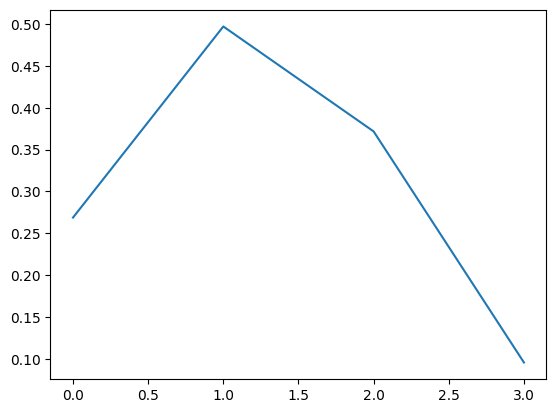

In [57]:
import casadi as cs
import matplotlib.pyplot as plt

x = cs.MX.sym('x',2) # Two states
p = cs.MX.sym('p')   # Free parameter

# Expression for ODE right-hand side
z = 1-x[1]**2
rhs = cs.vertcat(z*x[0]-x[1]+2*cs.tanh(p),x[0])

# ODE declaration with free parameter
ode = {'x':x,'p':p,'ode':rhs}

# Construct a Function that integrates over 1s
F = cs.integrator('F','cvodes',ode,{'tf':1})

# Control vector
u = cs.MX.sym('u',4,1)

x = [0,1]  # Initial state
for k in range(4):
  # Integrate 1s forward in time:
  # call integrator symbolically
  res = F(x0=x,p=u[k])
  x = res["xf"]


# NLP declaration
nlp = {'x':u,'f':cs.dot(u,u),'g':x}

# Solve using IPOPT
solver = cs.nlpsol('solver','ipopt',nlp)
res = solver(x0=0.2,lbg=0,ubg=0)

print(res["x"])
plt.plot(res["x"])

### Designing an MPC agent

Complete and tune the code below to construct an MPC routine that launches the satellite into orbit.

**Hint:** take a look at ``casadi.if_else`` and ``casadi.dot``

In [60]:
import casadi as cs

x = cs.MX.sym('x', 2) # speeds
v = cs.MX.sym('v', 2) # positions
t = cs.MX.sym('t', 1) # time
r = cs.MX.sym('r', 1) #reward

p = cs.MX.sym('p', 2) # action parameter


gamma = 0.99

# Expression for ODE right-hand side
system_rhs = cs.vertcat(
    cs.if_else(cs.norm_2(x) >= 1, v, 0),
    cs.if_else(t < 10, -.03*x/cs.norm_2(x)**3 + p, -.03 * x / cs.norm_2(x)**3),
)

t_rhs = 1
reward_rhs =  -((cs.dot(x, x) ** 0.5 - 1.5)**2 + cs.dot(p, p)) * gamma ** t

# ODE declaration with free parameter
ode = {'x': cs.vertcat(x,
                       v,
                       t,
                       r),
       'p':p,
       'ode': cs.vertcat(system_rhs,
                         t_rhs,
                         reward_rhs)}

# Construct a Function that integrates over 1s
F = cs.integrator('F','rk',ode,{'tf':1})


def complemented_state_transition(state_time_reward, action):
    state_time_reward = F(x0=state_time_reward,p=action)["xf"]
    return state_time_reward


class ModelPredictiveFeedback:
    def __init__(self, horizon, max_iter):
        self.horizon = horizon
        self.max_iter = max_iter
        self.last = 0.0 # On each successive iterations you want to resume from your previous configuration

    def __call__(self, state, time):
        u = cs.MX.sym('u', self.horizon * 2)
        x = cs.vertcat(state, time, 0)
        for k in range(self.horizon):
            x = complemented_state_transition(x, u[2*k : 2*(k+1)])
        r = x[-1]
        nlp = {'x': u,
               'f':-r,
               'g': (u[::2]**2+u[1::2]**2)**.5 - .03,
               }
        solver = cs.nlpsol('solver', 'ipopt', nlp, {"ipopt" : {"max_iter" : self.max_iter}})
        x0 = np.ones(self.horizon * 2)
        x0 /= norm(x0)
        x0 *= .02
        res = solver(x0=x0.tolist(), ubg=0)
        self.last = cs.vertcat(res['x'][2:], 0, 0)
        return np.array(res['x'][:2]).squeeze()


horizon = 20
iterations = 10
feedback = ModelPredictiveFeedback(horizon, iterations)


### Observe the results

In [61]:
test_and_plot(feedback)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       40
Number of nonzeros in Lagrangian Hessian.............:      820

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       20
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       20

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.7485148e+00 0.00e+00 6.67e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 